# Adversarial Robustness

### Notes and references

This tutorial is a simplified version of [Chapter 1 - Introduction to adversarial robustness](https://adversarial-ml-tutorial.org/introduction/). If you wish to expand on the topic of adversarial machine learning, the following are two great resources:

- https://adversarial-ml-tutorial.org
- https://www.youtube.com/watch?v=TwP-gKBQyic
- https://adversarial-ml-tutorial.org/adversarial_ml_slides_parts_1_4.pdf
- https://adversarial-ml-tutorial.org/adversarial_ml_slides_parts_2_3.pdf
- https://www.youtube.com/watch?v=dK5fi_HXJLg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction to adversarial robustness

To operate in open-world high-stakes environments, machine learning solutions will need to endure **unpredictable situations** and **carefully crafted and deceptive threats**. For instance, systems deployed into production may rely on neural networks to detect intrusions, but if adversaries can adapt their behaviour to elude detectors, systems **can be made to** fail.

---

## Evasion Attacks on Classifiers

This tutorial aims to provide a hands-on introductory experience to the topic of adversial robustness. Can we develop adversarial perturbations to deceive a classifier? Current research largely focuses on this specific notion of robustness, where an adversary attempts to induce a misclassification but can **only perturb inputs subject to a small p-norm constraint**, but multiple exist. With this in mind, let's go!

### Build our very first adversarial example

We will use the pre-trained [ResNet50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html;jsessionid=6af67a7196b4a3a58b33d654e493) model within PyTorch to classify a picture of a pig. Generally, in image classification problems with PyTorch, we would transform the image (to approximately zero-mean, unit variance) using the `torchvision.transforms` module. However, as we are planning to introduce perturbations in an unnormalised image space, we will build the transformations at PyTorch layers, so that we can directly feed the image in.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os

### Set paths (Mount Google Drive)



In [5]:
BASE_PATH = "/content/drive/MyDrive/Responsible and Transparent AI/Week4_lab/Lab1-resource/"

torch.Size([1, 3, 224, 224])


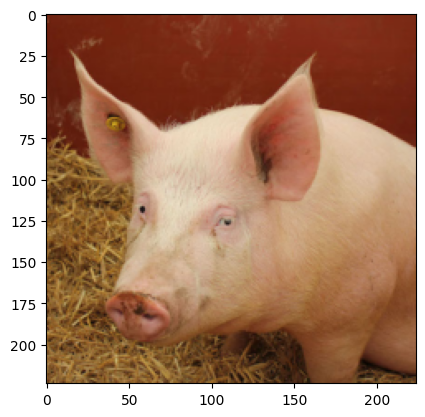

In [6]:
# Read the image, resize to 224 and convert to PyTorch Tensor
# 224 is the default size that most pre-trained classifiers take as input
# You can save the image of a pig from here: https://en.wikipedia.org/wiki/File:Show_Pig_(18097041013).jpg

img = Image.open(os.path.join(BASE_PATH, "pig.jpg"))
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),  # PIL = HWC, C = RGB -- needed for plt.
])

tensor = preprocess(img)[None,:,:,:]

print(tensor.shape)  # [batch, C, H, W]

# Plot the image (note that numpy uses HWC whereas Pytorch uses CHW, so we need to convert)
plt.imshow(tensor[0].numpy().transpose(1,2,0))  # removes batch dimension

Then, we will feed the image into the pre-trained ResNet50 model after some necessary transformations.

In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet50  # n.b., the pre-trained model can be directly downloaded

In [8]:
# Module to normalise an image so we can easily feed it in the pre-trained ResNet50 model
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# Values are standard normalization for ImageNet images
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Load the pre-trained ResNet50
model = resnet50(pretrained=True)
# Use the model for evaluation, and not for training
model.eval();

# Calculate the predictions
# Normalize the image and feed it into the model
predictions = model(norm(tensor))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


In [9]:
print(predictions.shape)

torch.Size([1, 1000])


The variable `predictions` is a 1000 dimensional vector containing the class logits for the 1000 ImageNet classes. To find the highest likelihood class, we simply take the index of the maximum value in this vector, and we can look this up in a list of ImageNet classes to find the corresponding label.

In [10]:
# The index of the maximum value in the vector is 215
print(predictions.max(dim=1))

torch.return_types.max(
values=tensor([20.9512], grad_fn=<MaxBackward0>),
indices=tensor([341]))


In [11]:
import json

# Save the json file from: https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
with open(os.path.join(BASE_PATH, "imagenet_class_index.json")) as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

# Check the class name of the predicted index
# Note that ImageNet has one class correpsonding to both “hog” and “pig”, so this is the correct label
print(imagenet_classes[predictions.max(dim=1)[1].item()])

hog


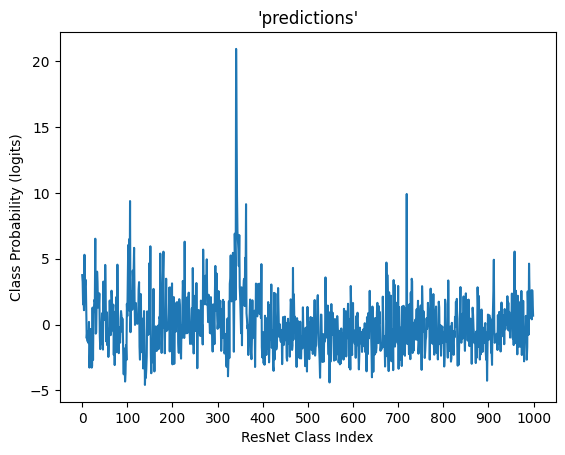

In [12]:
plt.plot(predictions.detach().numpy()[0])
plt.xlabel("ResNet Class Index")
plt.ylabel("Class Probability (logits)")
plt.title("'predictions'")
plt.xticks(np.arange(0,1001,100));

So how do we manipulate this image to make the classifier believe it is something else? The common approach to training a classifier is to optimise the parameters  𝜃 , so as to minimise the average loss over some training set. For deep neural networks, this gradient is computed efficiently via backpropagation. However, the beauty of automatic differentiation (the mathematical technique that underlies backpropagation), is that we aren't just limited to differentiating the loss with respect to  𝜃 (NN params); we can just as easily compute the gradient of the loss with respect to the input $x_i$  itself. This quantity will tell us how small changes to the image itself affect the loss function.

This is exactly what we're going to do to form an adversarial example. But **instead of adjusting the image to minimise the loss, as when optimising over the network parameters, we're going to adjust the image to maximise the loss.**  Of course, we cannot just optimise arbitrarily the adversarial example that is attempting to maximise the loss (there do exist, after all, some images that are not pigs, and if we change the image entirely, say to a dog, then it's not particularly impressive that we can "fool" the classifier into thinking it's not a pig). **So we instead need to ensure that our adversarial example is close to our original input  $x_i$.** Ok, enough discussion. Let's see what this looks like in practice.

In [13]:
# 341 is the class index corresponding to "hog". "norm" is an object of Normalize
print(nn.CrossEntropyLoss()(model(norm(tensor)),torch.LongTensor([341])).item())

0.003882253309711814


A loss of 0.0039 is pretty small: it would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig. The following example uses PyTorch's `SGD` optimizer to adjust our perturbation to the input to maximize the loss.

In [14]:
import torch.optim as optim

# Radius of allowable perturbations
epsilon = 2./255  # equiv to changing pixel values by 2 units (0 - 255 for RGB)
delta = torch.zeros_like(tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

iterations = 30

for t in range(iterations):
    # Calculate prediction with the injection of adversarial perturbations
    pred = model(norm(tensor + delta))
    # Maximise the loss between prediction and correct class
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    # Clears old gradients from the last step (otherwise we would just accumulate the gradients from all loss.backward() calls)
    opt.zero_grad()
    # Computes the derivative of the loss with regard to the parameters (or anything requiring gradients) using backpropagation
    loss.backward()
    # Causes the optimizer to take a step based on the gradients of the parameters -- update delta
    opt.step()
    # Allow the perturbation to have magnitude between [−epsilon, epsilon] in each of its components
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934622768312693
10 -0.01581377536058426
15 -0.08085538446903229
20 -12.66917610168457
25 -16.624135971069336
True class probability: 6.8625345406303495e-09


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-8}$ chance of being a pig. Instead, it turns out that this classifier is quite sure the image is a wombat, as we can see from the following code, which computes the maximum class and its probability.

Predicted class:  wombat
Predicted class index:  106
Predicted probability: 0.9999873638153076


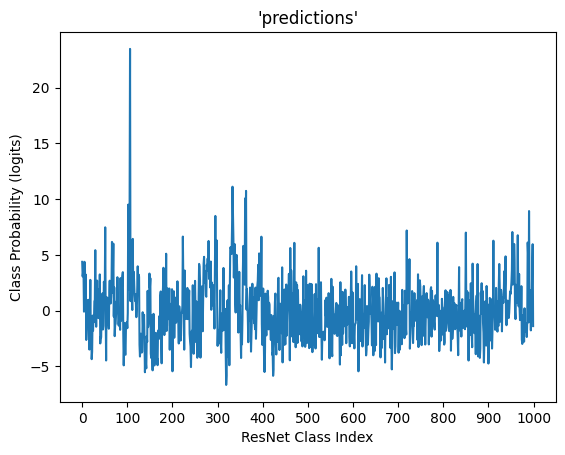

In [15]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted class index: ", max_class)
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

plt.plot(pred.detach().numpy()[0])
plt.xlabel("ResNet Class Index")
plt.ylabel("Class Probability (logits)")
plt.title("'predictions'")
plt.xticks(np.arange(0,1001,100));

So what does this wombat-pig look like?  Extremely similar to our original pig, unfortunately.



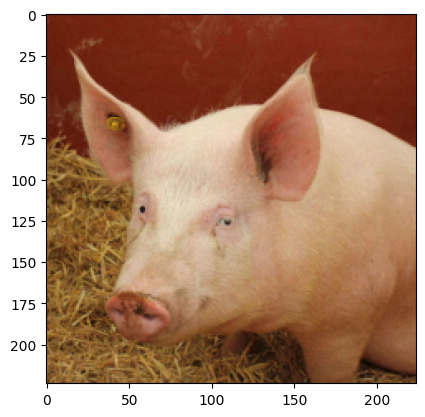

In [16]:
plt.imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))

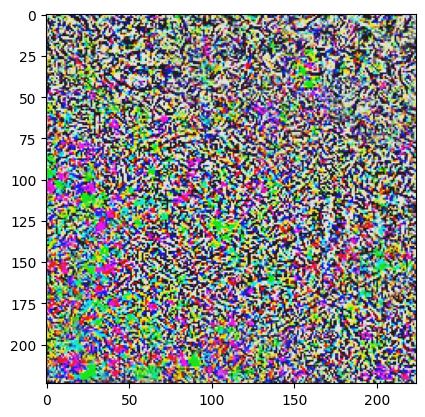

In [17]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

### But wait, what's a wombat?

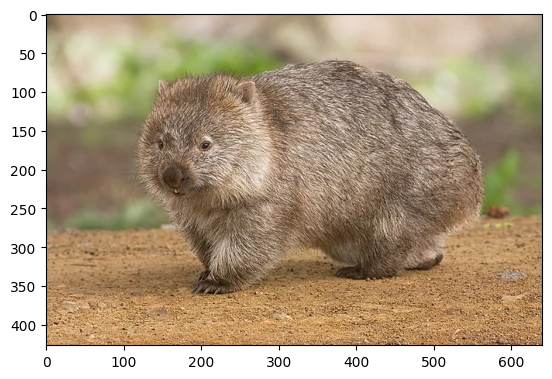

In [18]:
plt.imshow(Image.open(os.path.join(BASE_PATH, "wombat.png")))

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

### Targeted attacks
Ok, you might say.  This is impressive, but a wombat really isn't that different from a pig (?), so maybe the problem isn't that bad.  But it turns out this same technique can be used to make the image classified as virtually any class we desire.  This is known as a "targeted attack", and the only difference is that instead of trying to just maximise the loss of the correct class, **we maximise the loss of the correct class while also minimizing the loss of the target class.**

In [19]:
delta = torch.zeros_like(tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
iterations = 100
target_class = 404

for t in range(iterations):
    pred = model(norm(tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([target_class])))  # Crafted loss function
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.00604820251465
10 -0.08062744140625
20 -8.273968696594238
30 -14.132781982421875
40 -21.238548278808594
50 -27.012697219848633
60 -30.517364501953125
70 -32.54889678955078
80 -35.45109176635742
90 -35.6586799621582


In [20]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0, max_class].item())

Predicted class:  airliner
Predicted probability: 0.8762750029563904


As before, here's our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working).

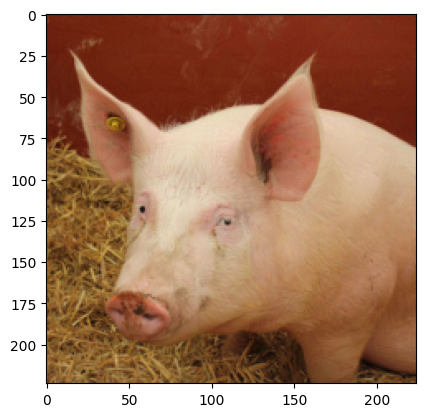

In [21]:
plt.imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))

And here is our airliner noise.

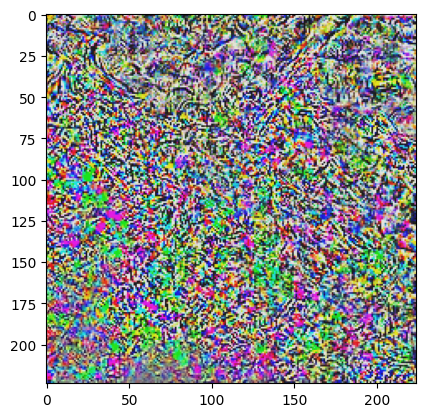

In [22]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

## **... Next steps (Strongly suggest you read it!)**

Now that you know about adversarial attacks, try this out on different datasets and different architectures. You may also create and train your own model, and then attempt to fool it using the same method. You can also try and see how the confidence in predictions vary as you change epsilon.

Recently, the community developed a powerful attack tool called AutoAttack, which uses an ensemble of four diverse attacks to reliably evaluate robustness. The details can be found in: AutoAttack (https://github.com/fra31/auto-attack), I would strongly suggest you to play with this attack tool, getting an sense of what is the current state-of-the-art adversarial attack method.

Also, there is a dedicated standardized benchmark for adversarial robustness at https://robustbench.github.io/, where you can get a full picture about the research on adversarial robustness including both adversarial attacks and defences.

For many more implementations of adversarial attacks and defenses, you may want to see the below adversarial toolboxes:
- Adversarial Robustness Toolbox: https://github.com/Trusted-AI/adversarial-robustness-toolbox/wiki/ART-Attacks
- Foolbox: https://github.com/bethgelab/foolbox
- CleverHans: https://github.com/cleverhans-lab/cleverhans

Though powerful, the attack shown in this tutorial was just the start of research into adversarial robustness. In addition to adversarial attacks, research has also led to the creation of defenses, which aims at creating robust machine learning models. We may cover the adversarial defence in the next lab session!